In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error
from autograd import grad
import autograd.numpy as np
import torch

In [2]:
#Q2 Fitting linear model using scikit-learn. 
X = np.array([[1, 2], [2, 4], [3, 6], [4, 8]])
y = np.array([2,3,4,5])
reg = LinearRegression()
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [3]:
def score(test_x,test_y,lm):
    prediction = lm.predict(test_x)
    error = mean_squared_error(prediction,test_y)
    return error**0.5

In [4]:
def divide_data(dataset):
    attr = dataset.columns
    train = []
    test = []
    for index,row in dataset.iterrows():
        if(index%3==0):
            test.append(row)
        else: 
            train.append(row)
    return pd.DataFrame(train),pd.DataFrame(test)

In [5]:
#Q3(a) Real estate problem using sklearn.

real_estate = pd.read_excel('real_estate.xlsx')
train,test = divide_data(real_estate)
features = train.columns
input_features = features[:-1]
target = features[-1]
X = train[input_features]
Y = train[target]
X_test = test[input_features]
Y_test = test[target]

#Q3(a) The error evaluated on the test set.
lm = LinearRegression()
lm.fit(X,Y)
score(X_test,Y_test,lm)

9.856774967008576

In [6]:
#Q3(b)The highest  coefficient features
maxi = 0
loc = 0
for i in range(len(lm.coef_)):
    if(lm.coef_[i]>maxi): 
        loc = i
        maxi = lm.coef_[i]

print("The maximum coefficient is ",maxi)
print("The maximum coefficient variable is ",features[i])

#It is not correct to compare the variable values as the values of variables are function of their units a
#and general trend of values. 

#We currently cannot comment on the importance of different features.

The maximum coefficient is  158.16876217973874
The maximum coefficient variable is  X6 longitude


In [7]:
#Q3(c)The standardization of data from 0 to 1 and its testing.
normalized = pd.DataFrame(features)
for f in features:
    normalized[f] = real_estate[f]/max(real_estate[f])
    
train_n,test_n = divide_data(normalized)
X_n = train_n[input_features]
Y_n = train_n[target]
lm.fit(X_n,Y_n)

maxi = 0
loc = 0
for i in range(len(lm.coef_)):
    if(lm.coef_[i]>maxi): 
        loc = i
        maxi = lm.coef_[i]

print("The maximum coefficient is ",maxi)
print("The maximum coefficient variable is ",features[i])
 
#This is now a robust measurement of the maximum instead of using only the feature
#This is now the most important.

The maximum coefficient is  0.29957850556990173
The maximum coefficient variable is  X6 longitude


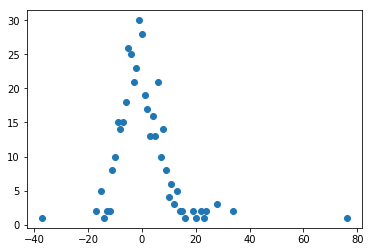

In [8]:
#Q3(d) Finding the distribution of residuals. 

residual_array = []
lm.fit(X,Y)
for index, row  in real_estate.iterrows(): 
    predict = lm.predict([row[:-1]])
    residual = row[-1] - predict[0]
    residual_array.append(round(residual))
    
dic = Counter(residual_array)
x = []
y = []
for i in dic.keys(): 
    x.append(i)
    y.append(dic[i])
    
plt.scatter(x,y)
#Discretizing the Data for finding residuals. 
#We choose discretization of -10 to 10 with 0.5 interval. 

In [9]:
def find_optimal_features(train,no):
    cutoff_1 = int(0.7*len(train))
    train_model = train[:cutoff_1]
    validate = train[cutoff_1:]
    
    se = set(itertools.combinations(features[1:-1],no))
    mini = 20000
    best_f = 0
    for s in se:
        sel_features = list(s)
        tr_x  = train_model[sel_features]
        tr_y = train_model[target]
        val_x = validate[sel_features]
        val_y = validate[target]
        lm.fit(tr_x,tr_y)
        per = score(val_x,val_y,lm)
        if(per<mini):
            best_f = s
            mini = per
        
    return best_f,mini


In [10]:
def gradientDescentPytorchRegression(X,Y,alpha=0.1): 
    
    X = np.insert(X,0,1,axis=1)
    cols = len(X[0])
    rows = len(X)
    theta = np.array([np.zeros(cols)]).T
    
    theta = torch.from_numpy(theta).float()
    theta.requires_grad_(True)
    
    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float() 
    
    for i in range(1000):
        
        theta.requires_grad_(True)
        
        predicted = torch.matmul(X,theta)
        
        error_val = sum((Y-predicted)**2)
        
        error_val.backward() 
        
        gradient = theta.grad
        
        theta.requires_grad_(False)
        theta = theta - alpha * gradient

    return theta.numpy().T[0]

In [11]:
def gradientDescentAutogradRegression(alpha = 0.1):
    
    grad_cost = grad(auto_cost)
    theta = np.zeros(len(X_auto[0]))
    for i in range(10000): 
        gr = grad_cost(theta)
        theta = theta-gr*alpha

    
    return theta

In [12]:
def gradientDescentRegression(X,y,alpha = 0.1):
    
    size_x,size_y = np.shape(X)
    X_ = np.ones([size_x,size_y+1])
    X_[:,1:] = X
    theta = np.zeros(len(X_[0]))
    for i in range(100): 
        gr = gradient(X_,y,theta)
        theta = theta-gr*alpha

    
    return theta

In [13]:
def greedy(train):
    cutoff_1 = int(0.7*len(train))
    train_model = train[:cutoff_1]
    validate = train[cutoff_1:]
    features = train.columns
    greed_f = []
    best_score = 100000
    cur_score = 0
    while True:
        flag = 0
        for i in range(1,len(features)-1):
            if features[i] not in greed_f:
                tr_x  = train_model[greed_f + [features[i]]]
                tr_y = train_model[features[-1]]
                val_x = validate[greed_f + [features[i]]]
                val_y = validate[features[-1]]
                lm.fit(tr_x,tr_y)
                per = score(val_x,val_y,lm)
                if(per<best_score):
                    flag = 1
                    best_f = greed_f+[features[i]]
                    best_score = per
        if(flag == 0):
            break
        else:
            greed_f = best_f
    return greed_f


In [14]:
def exhaustive_search(train):
    min_error = 100000
    chosen = 0
    for i in range(1,5):
        
        opt_features,error = find_optimal_features(train,i)
        if(error<min_error): 
            chosen = opt_features
            min_error = error
    return list(chosen),min_error
                
        
        

In [15]:
#Q3(e)(i) and (ii) Taking optimal features and finding its performance. 

real_estate = pd.read_excel('real_estate.xlsx')

train, test = divide_data(real_estate)

features = train.columns

greed_f = greedy(train)

opt_features,min_error = exhaustive_search(train)

test_x = test[opt_features]
train_x = train[opt_features]
train_y = train[features[-1]]
test_y = test[features[-1]]

lm.fit(train_x,train_y)

print("score with selected features",score(test_x,test_y,lm))


#Performance of entire model

test_x = test[features[:-1]]
train_x = train[features[:-1]]
train_y = train[features[-1]]
test_y = test[features[-1]]

lm.fit(train_x,train_y)
print("score with all features",score(test_x,test_y,lm))


#Performance with greedy features
train_x = train[greed_f]
train_y = train[features[-1]]
test_x = test[greed_f]
test_y = test[features[-1]]

lm.fit(train_x,train_y)
print("score greedy is obtained as",score(test_x,test_y,lm))


score with selected features 10.29021968269323
score with all features 9.856774967008576
score greedy is obtained as 9.866645460029128


In [16]:
def normalEquationRegression(X,y): 
    size_x,size_y = np.shape(X)
    X_ = np.ones([size_x,size_y+1])
    X_[:,1:] = X
    A = np.linalg.inv(np.dot(X_.T,X_))
    B = np.dot(X_.T,y)
    th = np.dot(A,B)
    return th

In [17]:
def gradient(X,y,theta): 
    rows = len(X)

    grad = np.zeros(len(theta))
    for j in range(len(theta)): 
        for i in range(len(X)):

            grad[j]+=-2*X[i,j]*error(X[i],y[i],theta)
    return 1.0*grad/rows
            
    

In [18]:
def auto_cost(theta):
    pred = np.dot(X_auto, theta)
    return np.sqrt(((pred - Y_auto) ** 2).mean(axis=None))

In [19]:
def error(x,y,theta):
    
    err = y - sum(x*theta)
    return err

In [20]:
def test_dataset(theta,X,Y):
    size_x,size_y = np.shape(X)
    X_t = np.ones([size_x,size_y+1])
    X_t[:,1:] = X
    error = 0.
    for i in range(len(X_t)): 
        row_i = X_t[i]
        dot =  np.dot(row_i,theta)
        error+= (Y[i]-dot)**2
    
    return (1.0*error/size_x)**0.5

In [21]:
#Q4(a),(b),(c) and (d) The optimal paramter list by normal equation
X = np.array([[1,3,6]]).T
Y = np.array([6,10,16]).T
t1 = normalEquationRegression(X,Y)


#Q4(b)Applying gradient Descent regression.
t2 = gradientDescentRegression(X,Y,0.05)

#Q4(c)Applying Autograd regression scheme
size_x,size_y = np.shape(X)
X_auto = np.ones([size_x,size_y+1])
X_auto[:,1:] = X
Y_auto = Y
t3 = gradientDescentAutogradRegression(0.05)

#Q4(d)The pytorch regression scheme.

X = np.array([[1,3,6]]).T
Y = np.array([[6,10,16]]).T
t4 = gradientDescentPytorchRegression(X,Y,alpha=0.01)

print("Normal Equation ", t1)
print("Gradient Descent ", t2)
print("AutoGrad Regression ", t3)
print("pytorch regression ",t4)

Normal Equation  [4. 2.]
Gradient Descent  [3.76333053 2.05234682]
AutoGrad Regression  [3.97758245 1.8986462 ]
pytorch regression  [3.9999928 2.0000017]


In [22]:
#Q4(e)Illustrating the above on the real estate dataset.
file = pd.read_excel('real_estate.xlsx')
train, test = divide_data(file)
X_train = train[train.columns[:-1]]
Y_train = train[train.columns[-1]]
X_test = test[test.columns[:-1]]
Y_test = test[test.columns[-1]]

th = normalEquationRegression(X_train,Y_train)
X_test = np.array(X_test.values)
Y_test = np.array(Y_test.values)
error1  = test_dataset(th,X_test,Y_test)

#Q4(e)Illustrating the above on the real estate dataset with gradient descent.

X_train = np.array(X_train.values)
Y_train = np.array(Y_train.values) 
theta_opt = gradientDescentRegression(X_train,Y_train,0.0000001)
error2 = test_dataset(theta_opt,X_test,Y_test)

size_x,size_y = np.shape(X_train)
X_auto = np.ones([size_x,size_y+1])
X_auto[:,1:] = X_train
Y_auto = Y_train
theta_opt = gradientDescentAutogradRegression(0.000001)

size_x,size_y = np.shape(X_train)
X_p = X_train
error3 = test_dataset(theta_opt,X_test,Y_test)

X_py = X_train
Y_py = np.array([Y_train]).T
theta_opt = gradientDescentPytorchRegression(X_py,Y_py,0.0000000005)
error4 = test_dataset(theta_opt,X_test,Y_test)

print("The error obtained using normal Regression is ",error1)
print("The error obtained using Gradient Descent is ", error2)
print("The error obtained using Autograd linear Regression is ",error3)
print("The error obtained using Pytorch Scheme is ",error4)

The error obtained using normal Regression is  9.856774936956427
The error obtained using Gradient Descent is  11.25784001214205
The error obtained using Autograd linear Regression is  11.158562332904138
The error obtained using Pytorch Scheme is  11.217159733055436


In [23]:
#Q5 Coefficients in case of 4th degree. 

x = np.arange(0, 20.1, 0.1)
np.random.seed(0)
y = 1*x**5 + 3*x**4 - 100*x**3 + 8*x**2 -300*x - 1e5 + np.random.randn(len(x))*1e5

X1 = np.column_stack((x,x**2,x**3,x**4,x**5))
theta = normalEquationRegression(X1,y)
print(theta)

#Q5 Coefficients in case of 5 degree
X2 = np.column_stack((x,x**2,x**3,x**4))
theta = normalEquationRegression(X2,y)
print(theta)

[ 8.82345707e+03 -5.75536517e+04  3.57964583e+03  7.53760679e+02
 -9.47499055e+01  3.65204554e+00]
[ 5.29201684e+04 -1.26089185e+05  2.78067073e+04 -2.48850506e+03
  8.78523715e+01]
